# Graph Convolutional Networks for fMRI Analysis

In [26]:
!pip install torch-geometric

  Obtaining dependency information for torch-geometric from https://files.pythonhosted.org/packages/72/33/7bb7269fc46f40b77de035c285fbb21f8943b7fba9c69e6857e5a4ef9f57/torch_geometric-2.5.0-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/64.2 kB ? eta -:--:--
     ------------ ------------------------- 20.5/64.2 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 64.2/64.2 kB 855.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.1 MB 1.3 MB/s eta 0:00:01
   ------- -------------------------------- 0.2/1.1 MB 2.1 MB/s eta 0:00:01
   ------------- -------------------------- 0.4/1.1 MB 2.2 MB/s eta 0:00:01
   ------------------ --------------------- 0.5/1.1 MB 2.7 MB/s eta 0:00:01
   ------------------------- -------------- 0.7/1.1 MB 2.7 MB/s eta 0:00:01
   ------------------------------- 

In [37]:
import os
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nilearn import datasets
from nilearn import plotting
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d
from torch_geometric.nn import EdgeConv, GCNConv, GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import from_networkx

import networkx as nx
from networkx.convert_matrix import from_numpy_array

## Data Preparation

In [6]:
dataset_path = 'dataset'
corr_matrices_dir = f'{dataset_path}/corr_matrices'
pcorr_matrices_dir = f'{dataset_path}/pcorr_matrices'
avg_pcorr_file = f'{dataset_path}/avg_pcorr.csv'
time_series_dir = f'{dataset_path}/time_series'
labels_file = f'{dataset_path}/labels.csv'

# os.makedirs(corr_matrices_dir)
# os.makedirs(pcorr_matrices_dir)
# os.makedirs(time_series_dir)

In [3]:
# fetch atlas that parcellates the brain into regions of interest
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas.maps
atlas_labels = atlas.labels

# fetch raw fMRI data from OpenNeuro
data = datasets.fetch_development_fmri()

In [7]:
# extract signal in each region of interest ovr time using atlas

masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, memory='nilearn_cache')

time_series = [0] * len(data.func)
labels = [0] * len(data.func)

for i in range(0, len(data.func)):
    sub_num = int(data.phenotypic[i][0][9:]) - 1
    
    ts = masker.fit_transform(data.func[i], confounds = data.confounds[i])
    time_series[sub_num] = ts
    labels[sub_num] = data.phenotypic[i][3]
    

for i in range(len(time_series)):
    np.savetxt(f'{time_series_dir}/time_series_{i:04d}.csv', time_series[i], delimiter=',')

C:\Users\Sadie\anaconda3\Lib\site-packages\nilearn\maskers\base_masker.py:268: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(


In [21]:
# calculating partial correlation matrix for each time series and taking mean
# will serve as basis for edges in later graphs

corr_measure = ConnectivityMeasure(kind="correlation")
pcorr_measure = ConnectivityMeasure(kind="partial correlation")

corr_matrices = corr_measure.fit_transform(time_series)
pcorr_matrices = pcorr_measure.fit_transform(time_series)

avg_pcorr_matrix = np.mean(pcorr_matrices, axis=0)
np.savetxt(avg_pcorr_file, avg_pcorr_matrix, delimiter=',')

for i in range(0, len(corr_matrices)):
    np.savetxt(f'{corr_matrices_dir}/corr_{i:04d}.csv', corr_matrices[i], delimiter=',')
    np.savetxt(f'{pcorr_matrices_dir}/pcorr_{i:04d}.csv', pcorr_matrices[i], delimiter=',')
    
label_nums = [0 if label == 'child' else 1 for label in labels]
np.savetxt(labels_file, np.asarray(label_nums).astype(int), delimiter=',')


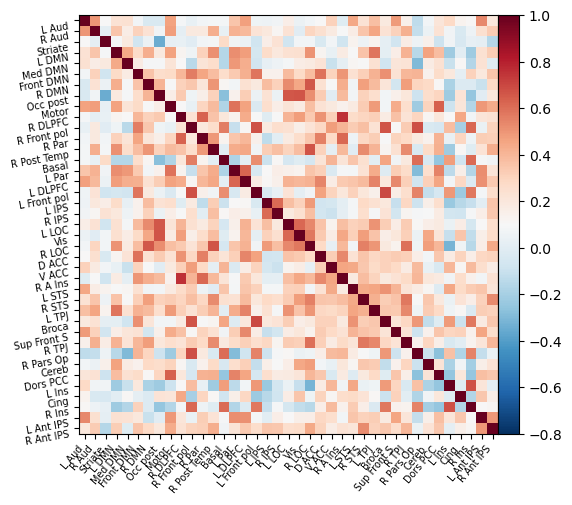

In [22]:
# partial correlation matrix visualization

plotting.plot_matrix(corr_matrices[0], labels=atlas_labels, colorbar=True, vmax=1, vmin=-0.8)


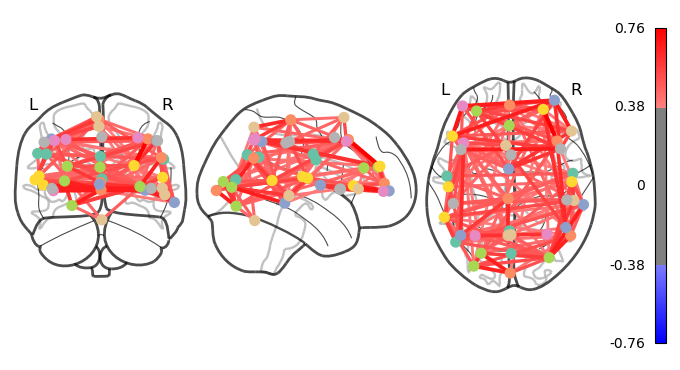

In [23]:
# connectome over brain schematic

# center coordinates of each ROI
coords = atlas.region_coords

plotting.plot_connectome(corr_matrices[0], coords, edge_threshold='80%', colorbar=True)

In [30]:
class DevDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, neighbors=10):
        self.neighbors = neighbors
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    def process(self):
        """
        Converts raw data into GNN-readable format by constructing graph out of
        connectivity matrices
        """
        
        # paths of connectivity matrices
        corr_path_list = sorted(os.listdir(corr_matrices_dir), key=lambda x: int(x[-8:-4]))
        pcorr_path_list = sorted(os.listdir(pcorr_matrices_dir), key=lambda x: int(x[-8:-4]))
        
        graphs = []
        labels = torch.from_numpy(np.loadtxt(labels_file, delimiter=','))
        for i in range(0, len(corr_path_list)):
            corr_matrix_path = os.path.join(corr_matrices_dir, corr_path_list[i])
            pcorr_matrix_path = os.path.join(pcorr_matrices_dir, pcorr_path_list[i])
            
            # pushing partial correlation matrices through pipeline
            pcorr_matrix_np = np.loadtxt(pcorr_matrix_path, delimiter=',')
            
            index = np.abs(pcorr_matrix_np).argsort(axis=1)
            n_rois = pcorr_matrix_np.shape[0]
            
            # take only top k correlates to reduce number of edges
            for j in range(n_rois):
                for k in range(n_rois - self.neighbors):
                    pcorr_matrix_np[j, index[j, k]] = 0
                
                for k in range(n_rois - self.neighbors, n_rois):
                    pcorr_matrix_np[j, index[j, k]] = 1
                    
            pcorr_matrix_nx = from_numpy_array(pcorr_matrix_np)
            pcorr_matrix_data = from_networkx(pcorr_matrix_nx)
            
            # correlation matrix - features
            corr_matrix_np = np.loadtxt(corr_matrix_path, delimiter=',')
            
            pcorr_matrix_data.x = torch.tensor(corr_matrix_np).float()
            pcorr_matrix_data.y = labels[i].type(torch.LongTensor)
            
            # add to running list of all dataset items
            graphs.append(pcorr_matrix_data)
            
        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

In [31]:
dataset = DevDataset('dataset_pyg')
dataset = dataset.shuffle()

train_share = int(len(dataset) * 0.8)

train_data = dataset[:train_share]
test_data = dataset[train_share:]

Processing...
Done!


## Model Definition

In [33]:
class GraphNetwork(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        
        # initialize MLPs used by EdgeConv layers
        self.mlp1 = Sequential(Linear(2 * dataset.num_node_features, hidden_channels), ReLU())
        self.mlp2 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())
        self.mlp3 = Sequential(torch.nn.Linear(2 * hidden_channels, hidden_channels), ReLU())
        
        # initialize EdgeConv layers
        self.conv1 = EdgeConv(self.mlp1, aggr='max')
        self.conv2 = EdgeConv(self.mlp2, aggr='max')
        self.conv3 = EdgeConv(self.mlp3, aggr='max')
        
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        
        self.linear = torch.nn.Linear(hidden_channels, dataset.num_classes)
        
    def forward(self, data):
        """ Performs forward pass on simplified cGCN
        
        Parameters:
        data (Data): Graph being passed into network
        
        Returns:
        torch.Tensor (N x 2): Probability distribution over class labels
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        
        x = global_mean_pool(x, batch)
        x = self.linear(x)
        x = F.softmax(x, dim=1)
        
        return x

## Training

In [40]:
def train(model, loss_fn, device, data_loader, optimizer):
    """ Performs an epoch of model training
    
    Parameters:
    model (nn.Module): model for training
    loss_fn (nn.Module): loss function for training
    device (torch.Device): device used for training
    data_loader (torch.utils.data.DataLoader): data loader containing all batches
    optimizer (torch.optim.Optimizer): optimizer used to update model
    
    Returns:
    float: total loss for epoch
    """
    
    model.train()
    loss = 0
    
    for batch in data_loader:
        batch = batch.to(device)
        
        optimizer.zero_grad()
        out = model(batch)
        
        loss = loss_fn(out, batch.y)
        
        loss.backward()
        optimizer.step()
        
    return loss.item()

def eval(model, device, loader):
    """ Calculate accuracy for all examples in a Dataloader
    
    Parameters:
    model (nn.Module): model for evaluation
    device (torch.Device): device used for training
    loader (torch.utils.data.DataLoader): data loader containing examples to test
    """
    
    model.eval()
    cor = 0
    tot = 0
    
    for batch in loader:
        batch = batch.to(device)
        
        with torch.no_grad():
            pred = torch.argmax(model(batch), 1)
            
        y = batch.y
        cor += (pred == y).sum()
        tot += pred.shape[0]
        
    return cor / tot

Epoch: 01,Loss: -0.6002,Train: 80.65%,Test: 74.19%
Epoch: 02,Loss: -0.6720,Train: 83.87%,Test: 77.42%
Epoch: 03,Loss: -0.8259,Train: 86.29%,Test: 77.42%
Epoch: 04,Loss: -0.9017,Train: 86.29%,Test: 74.19%
Epoch: 05,Loss: -0.9567,Train: 96.77%,Test: 83.87%
Epoch: 06,Loss: -0.9823,Train: 99.19%,Test: 83.87%
Epoch: 07,Loss: -0.9963,Train: 100.00%,Test: 83.87%
Epoch: 08,Loss: -0.9975,Train: 100.00%,Test: 87.10%
Epoch: 09,Loss: -0.9986,Train: 100.00%,Test: 90.32%
Epoch: 10,Loss: -0.9908,Train: 100.00%,Test: 90.32%
Epoch: 11,Loss: -0.9960,Train: 99.19%,Test: 90.32%
Epoch: 12,Loss: -0.9876,Train: 98.39%,Test: 83.87%
Epoch: 13,Loss: -0.9997,Train: 100.00%,Test: 90.32%
Epoch: 14,Loss: -0.9993,Train: 100.00%,Test: 87.10%
Epoch: 15,Loss: -0.9916,Train: 100.00%,Test: 90.32%
Epoch: 16,Loss: -0.9829,Train: 100.00%,Test: 87.10%
Epoch: 17,Loss: -0.9901,Train: 100.00%,Test: 87.10%
Epoch: 18,Loss: -0.9942,Train: 99.19%,Test: 83.87%
Epoch: 19,Loss: -1.0000,Train: 100.00%,Test: 87.10%
Epoch: 20,Loss: -0.99

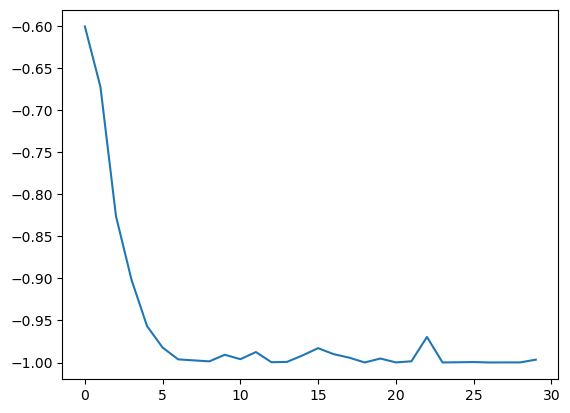

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphNetwork(32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

loss_fn = torch.nn.NLLLoss()
losses = []

for epoch in range(0, 30):
    loss = train(model, loss_fn, device, train_loader, optimizer)
    train_result = eval(model, device, train_loader)
    test_result = eval(model, device, test_loader)
    
    losses.append(loss)
    
    print(f'Epoch: {epoch + 1:02d},'
          f'Loss: {loss:.4f},'
          f'Train: {100 * train_result:.2f}%,'
          f'Test: {100 * test_result:.2f}%')
    
plt.plot(losses)
plt.show()